<a href="https://colab.research.google.com/github/DmitriiGoro/ML_2024_3_term/blob/master/LabWorks/lab02_main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
# (re-)load layers
%run modules_downloaded.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])
print(X1)

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(criterion)

# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-4, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

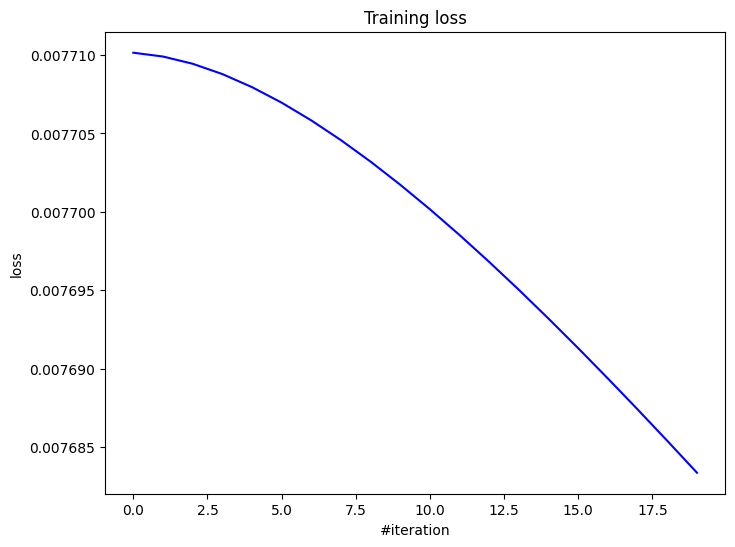

Current loss: 0.007683


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

--2024-12-16 18:40:24--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2024-12-16 18:40:24 (30.4 MB/s) - ‘mnist.py’ saved [2697/2697]



In [ ]:
import keras
import numpy as np

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


One-hot encode the labels first.

In [ ]:
def one_hot(labels):
    return np.eye(10)[labels.reshape(-1)]

one_hot_y_train = one_hot(y_train)
one_hot_y_val = one_hot(y_val)
one_hot_y_test = one_hot(y_test)

X_train = X_train.reshape([len(X_train),-1])
X_val = X_val.reshape([len(X_val),-1])
X_test = X_test.reshape([len(X_test),-1])

def accuracy(prediction, label):
    pred = np.argmax(prediction, axis = -1)
    return 1 - len(np.nonzero(label-pred)[0])/len(label)

In [ ]:
print(X_train.shape)
print(one_hot_y_train.shape)
print(X_val.shape)
print(one_hot_y_val.shape)
print(X_test.shape)
print(one_hot_y_test.shape)

(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)
(10000, 784)
(10000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [ ]:
net_relu = Sequential()
net_relu.add(Linear(28*28, 200))
net_relu.add(ReLU())
net_relu.add(Linear(200,10))
net_relu.add(LogSoftMax())
criterion_relu = ClassNLLCriterion()

net_elu = Sequential()
net_elu.add(Linear(28*28, 200))
net_elu.add(ELU())
net_elu.add(Linear(200,10))
net_elu.add(LogSoftMax())
criterion_elu = ClassNLLCriterion()

net_leakrelu = Sequential()
net_leakrelu.add(Linear(28*28, 200))
net_leakrelu.add(LeakyReLU())
net_leakrelu.add(Linear(200,10))
net_leakrelu.add(LogSoftMax())
criterion_leakrelu = ClassNLLCriterion()

net_soft = Sequential()
net_soft.add(Linear(28*28, 200))
net_soft.add(SoftPlus())
net_soft.add(Linear(200,10))
net_soft.add(LogSoftMax())
criterion_soft = ClassNLLCriterion()

time_relu = 0
time_elu = 0
time_leakrelu = 0
time_soft = 0

val_acc_relu = []
val_loss_relu = []
train_acc_relu = []
train_loss_relu = []
test_loss_relu = []
test_acc_relu = []

val_acc_elu = []
val_loss_elu = []
train_acc_elu = []
train_loss_elu = []
test_loss_elu = []
test_acc_elu = []

val_acc_leakrelu = []
val_loss_leakrelu = []
train_acc_leakrelu = []
train_loss_leakrelu = []
test_loss_leakrelu = []
test_acc_leakrelu = []

val_acc_soft = []
val_loss_soft = []
train_acc_soft = []
train_loss_soft = []
test_loss_soft = []
test_acc_soft = []

n_epoch = 30
batch_size = 1000
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

In [ ]:
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):

        net_relu.zeroGradParameters()
        net_elu.zeroGradParameters()
        net_leakrelu.zeroGradParameters()
        net_soft.zeroGradParameters()

        time_relu_start = time()
        predictions_relu = net_relu.forward(x_batch)
        loss_relu = criterion_relu.forward(predictions_relu, y_batch)
        dp_relu = criterion_relu.backward(predictions_relu, y_batch)
        net_relu.backward(x_batch, dp_relu)
        sgd_momentum(net_relu.getParameters(),
                     net_relu.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        time_relu += time() - time_relu_start

        time_elu_start = time()
        predictions_elu = net_elu.forward(x_batch)
        loss_elu = criterion_elu.forward(predictions_elu, y_batch)
        dp_elu = criterion_elu.backward(predictions_elu, y_batch)
        net_elu.backward(x_batch, dp_elu)
        sgd_momentum(net_elu.getParameters(),
                     net_elu.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        time_elu += time() - time_elu_start

        time_leakrelu_start = time()
        predictions_leakrelu = net_leakrelu.forward(x_batch)
        loss_leakrelu = criterion_leakrelu.forward(predictions_leakrelu, y_batch)
        dp_leakrelu = criterion_leakrelu.backward(predictions_leakrelu, y_batch)
        net_leakrelu.backward(x_batch, dp_leakrelu)
        sgd_momentum(net_leakrelu.getParameters(),
                     net_leakrelu.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        time_leakrelu +=  time() - time_leakrelu_start

        time_soft_start = time()
        predictions_soft = net_soft.forward(x_batch)
        loss_soft = criterion_soft.forward(predictions_soft, y_batch)
        dp_soft = criterion_soft.backward(predictions_soft, y_batch)
        net_soft.backward(x_batch, dp_soft)
        sgd_momentum(net_soft.getParameters(),
                     net_soft.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
        time_soft += time() - time_soft_start


    pred_train_relu = net_relu.forward(X_train)
    train_loss_relu.append(criterion_relu.forward(pred_train_relu, one_hot_y_train))
    train_acc_relu.append(accuracy(pred_train_relu,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_relu = net_relu.forward(X_val)
    val_loss_relu.append(criterion_relu.forward(pred_val_relu, one_hot_y_val))
    val_acc_relu.append(accuracy(pred_val_relu,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_relu = net_relu.forward(X_test)
    test_loss_relu.append(criterion_relu.forward(pred_test_relu, one_hot_y_test))
    test_acc_relu.append(accuracy(pred_test_relu,np.argmax(one_hot_y_test,axis = -1)))


    pred_train_elu = net_elu.forward(X_train)
    train_loss_elu.append(criterion_elu.forward(pred_train_elu, one_hot_y_train))
    train_acc_elu.append(accuracy(pred_train_elu,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_elu = net_elu.forward(X_val)
    val_loss_elu.append(criterion_elu.forward(pred_val_elu, one_hot_y_val))
    val_acc_elu.append(accuracy(pred_val_elu,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_elu = net_elu.forward(X_test)
    test_loss_elu.append(criterion_elu.forward(pred_test_elu, one_hot_y_test))
    test_acc_elu.append(accuracy(pred_test_elu,np.argmax(one_hot_y_test,axis = -1)))


    pred_train_leakrelu = net_leakrelu.forward(X_train)
    train_loss_leakrelu.append(criterion_leakrelu.forward(pred_train_leakrelu, one_hot_y_train))
    train_acc_leakrelu.append(accuracy(pred_train_leakrelu,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_leakrelu = net_leakrelu.forward(X_val)
    val_loss_leakrelu.append(criterion_leakrelu.forward(pred_val_leakrelu, one_hot_y_val))
    val_acc_leakrelu.append(accuracy(pred_val_leakrelu,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_leakrelu = net_leakrelu.forward(X_test)
    test_loss_leakrelu.append(criterion_leakrelu.forward(pred_test_leakrelu, one_hot_y_test))
    test_acc_leakrelu.append(accuracy(pred_test_leakrelu,np.argmax(one_hot_y_test,axis = -1)))


    pred_train_soft = net_soft.forward(X_train)
    train_loss_soft.append(criterion_soft.forward(pred_train_soft, one_hot_y_train))
    train_acc_soft.append(accuracy(pred_train_soft,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_soft = net_soft.forward(X_val)
    val_loss_soft.append(criterion_soft.forward(pred_val_soft, one_hot_y_val))
    val_acc_soft.append(accuracy(pred_val_soft,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_soft = net_soft.forward(X_test)
    test_loss_soft.append(criterion_soft.forward(pred_test_soft, one_hot_y_test))
    test_acc_soft.append(accuracy(pred_test_soft,np.argmax(one_hot_y_test,axis = -1)))

n_epoch = 30 out of 30
Current duration of training 
 for ReLU: 1083.4718 s, 
 for ELU: 1094.6637 s, 
 for LeakyReLU: 1089.6611 s, 
 for SoftPlus: 1097.8491 s


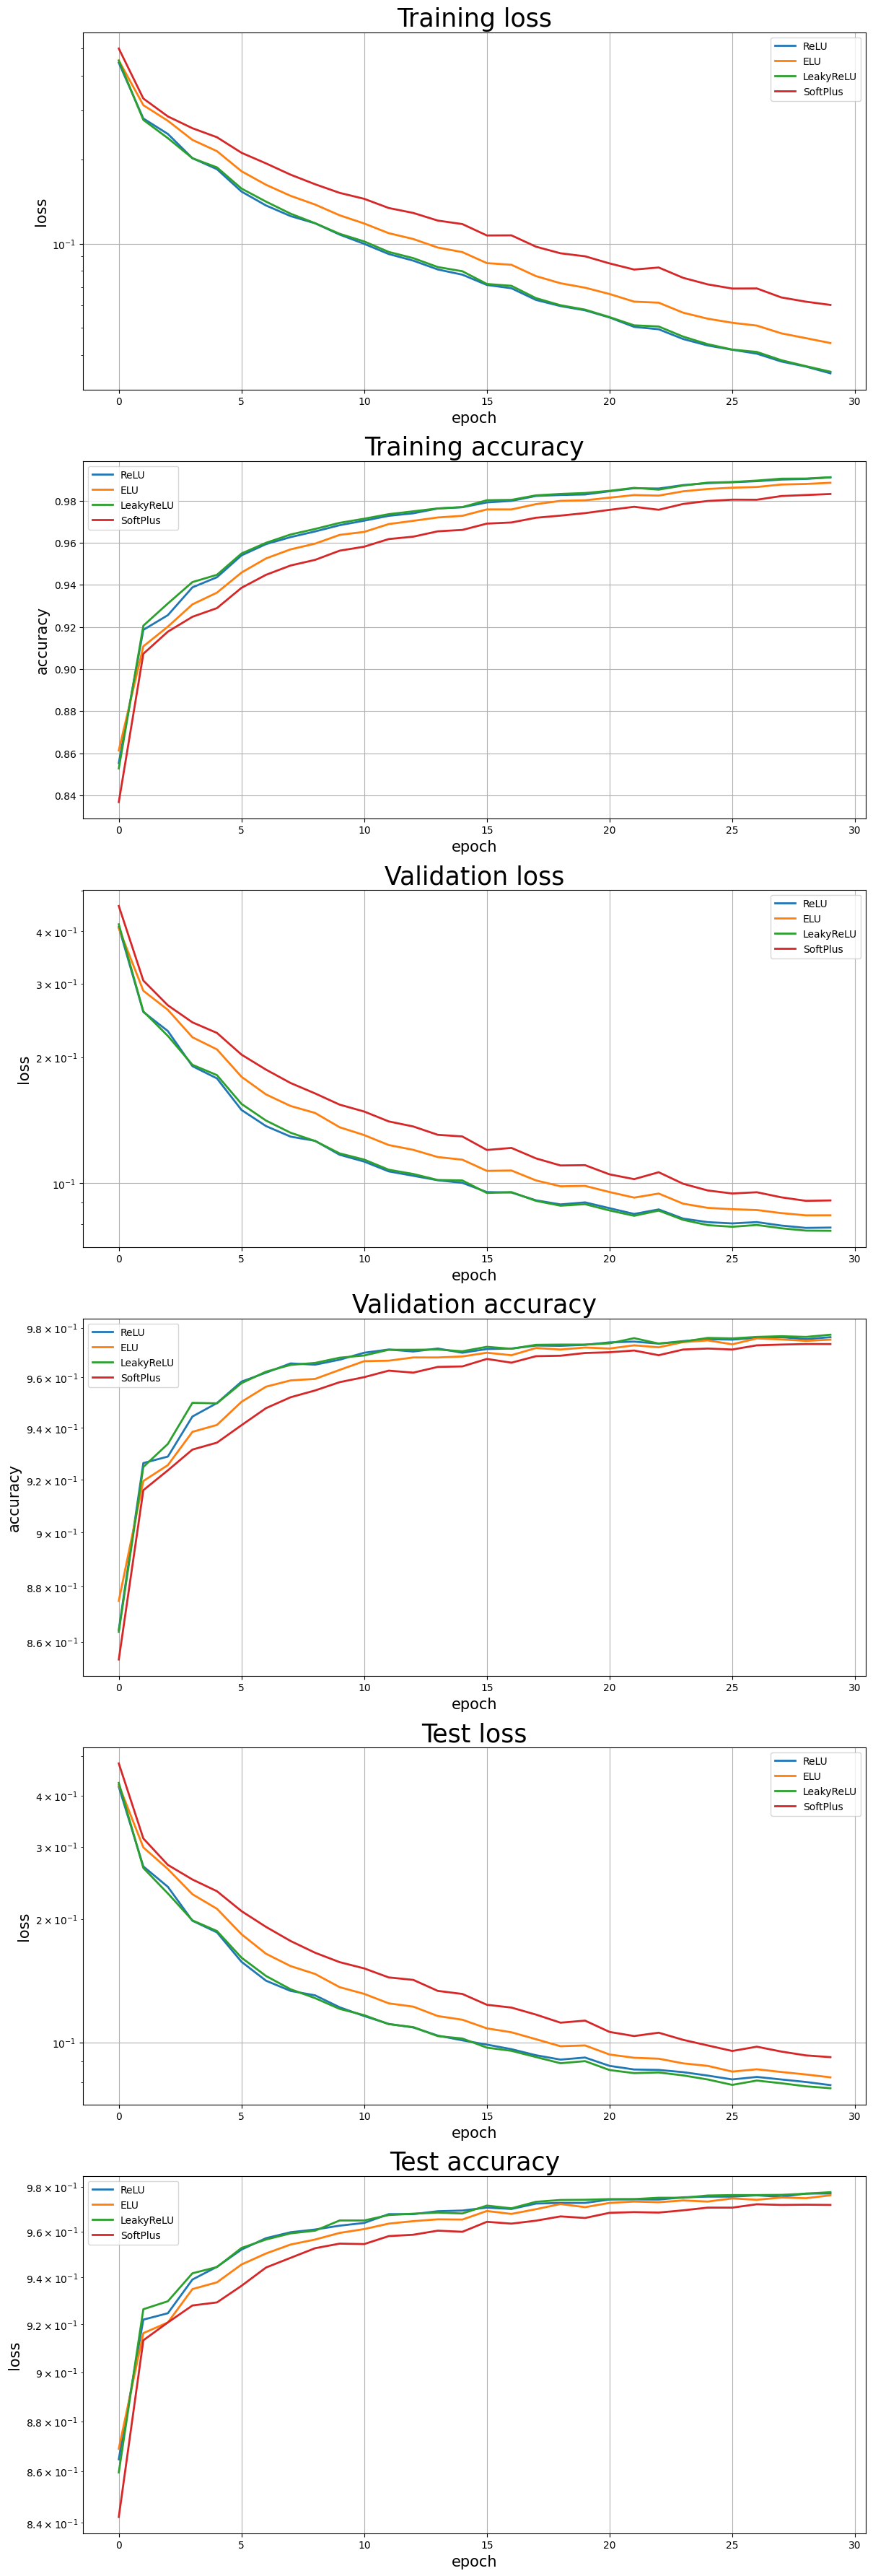

Resulting duration of training: 
 for ReLU: 1083.4718 s, 
 for ELU: 1094.6637 s, 
 for LeakyReLU: 1089.6611 s, 
 for SoftPlus: 1097.8491 s


In [ ]:
    display.clear_output(wait=True)
    print('n_epoch = {} out of {}'.format(i+1,n_epoch))
    print('Current duration of training \n for ReLU: {} s, \n for ELU: {} s, \n for LeakyReLU: {} s, \n for SoftPlus: {} s'.format(round(time_relu,4), round(time_elu,4), round(time_leakrelu,4), round(time_soft,4)))
    plt.figure(figsize=(14, 45))

    plt.subplot(6,1,1)
    plt.title("Training loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(train_loss_relu, lw = 2, label = 'ReLU')
    plt.semilogy(train_loss_elu, lw = 2, label = 'ELU')
    plt.semilogy(train_loss_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(train_loss_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()


    plt.subplot(6,1,2)
    plt.title("Training accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("accuracy", fontsize = 15)
    plt.plot(train_acc_relu, lw = 2, label = 'ReLU')
    plt.plot(train_acc_elu, lw = 2, label = 'ELU')
    plt.plot(train_acc_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.plot(train_acc_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()

    plt.subplot(6,1,3)
    plt.title("Validation loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(val_loss_relu, lw = 2, label = 'ReLU')
    plt.semilogy(val_loss_elu, lw = 2, label = 'ELU')
    plt.semilogy(val_loss_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(val_loss_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()

    plt.subplot(6,1,4)
    plt.title("Validation accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("accuracy", fontsize = 15)
    plt.semilogy(val_acc_relu, lw = 2, label = 'ReLU')
    plt.semilogy(val_acc_elu, lw = 2, label = 'ELU')
    plt.semilogy(val_acc_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(val_acc_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()


    plt.subplot(6,1,5)
    plt.title("Test loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_loss_relu, lw = 2, label = 'ReLU')
    plt.semilogy(test_loss_elu, lw = 2, label = 'ELU')
    plt.semilogy(test_loss_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(test_loss_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()

    plt.subplot(6,1,6)
    plt.title("Test accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_acc_relu, lw = 2, label = 'ReLU')
    plt.semilogy(test_acc_elu, lw = 2, label = 'ELU')
    plt.semilogy(test_acc_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(test_acc_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()

    plt.show()
    print('Resulting duration of training: \n for ReLU: {} s, \n for ELU: {} s, \n for LeakyReLU: {} s, \n for SoftPlus: {} s'.format(round(time_relu,4), round(time_elu,4), round(time_leakrelu,4), round(time_soft,4)))

Сравнивая различные показатели точности, видно, что ReLU и LeakyReLU продемонстрировали результаты лучше, чем SoftPlus и ELU. Точность на тесте у ELU сопоставима с ReLU и LeakyReLU. Скорость выполнения одинакова у всех функций.

BatchNormalization insert

In [ ]:
n_epoch = 30
batch_size = 1000


net_r = Sequential()
net_r.add(Linear(28*28, 100))
net_r.add(ReLU())
net_r.add(Linear(100,10))
net_r.add(LogSoftMax())
criterion_r = ClassNLLCriterion()

net_norm = Sequential()
net_norm.add(Linear(28*28, 100))
net_norm.add(BatchNormalization())
net_norm.add(ChannelwiseScaling(100))
net_norm.add(ReLU())
net_norm.add(Linear(100,10))
net_norm.add(BatchNormalization())
net_norm.add(ChannelwiseScaling(10))
net_norm.add(LogSoftMax())
criterion_norm = ClassNLLCriterion()

n_epoch = 30 out of 30
Current duration of training: 
 for ReLU without normalization: 556.799 s, 
 for ReLU with normalization: 565.5062 s


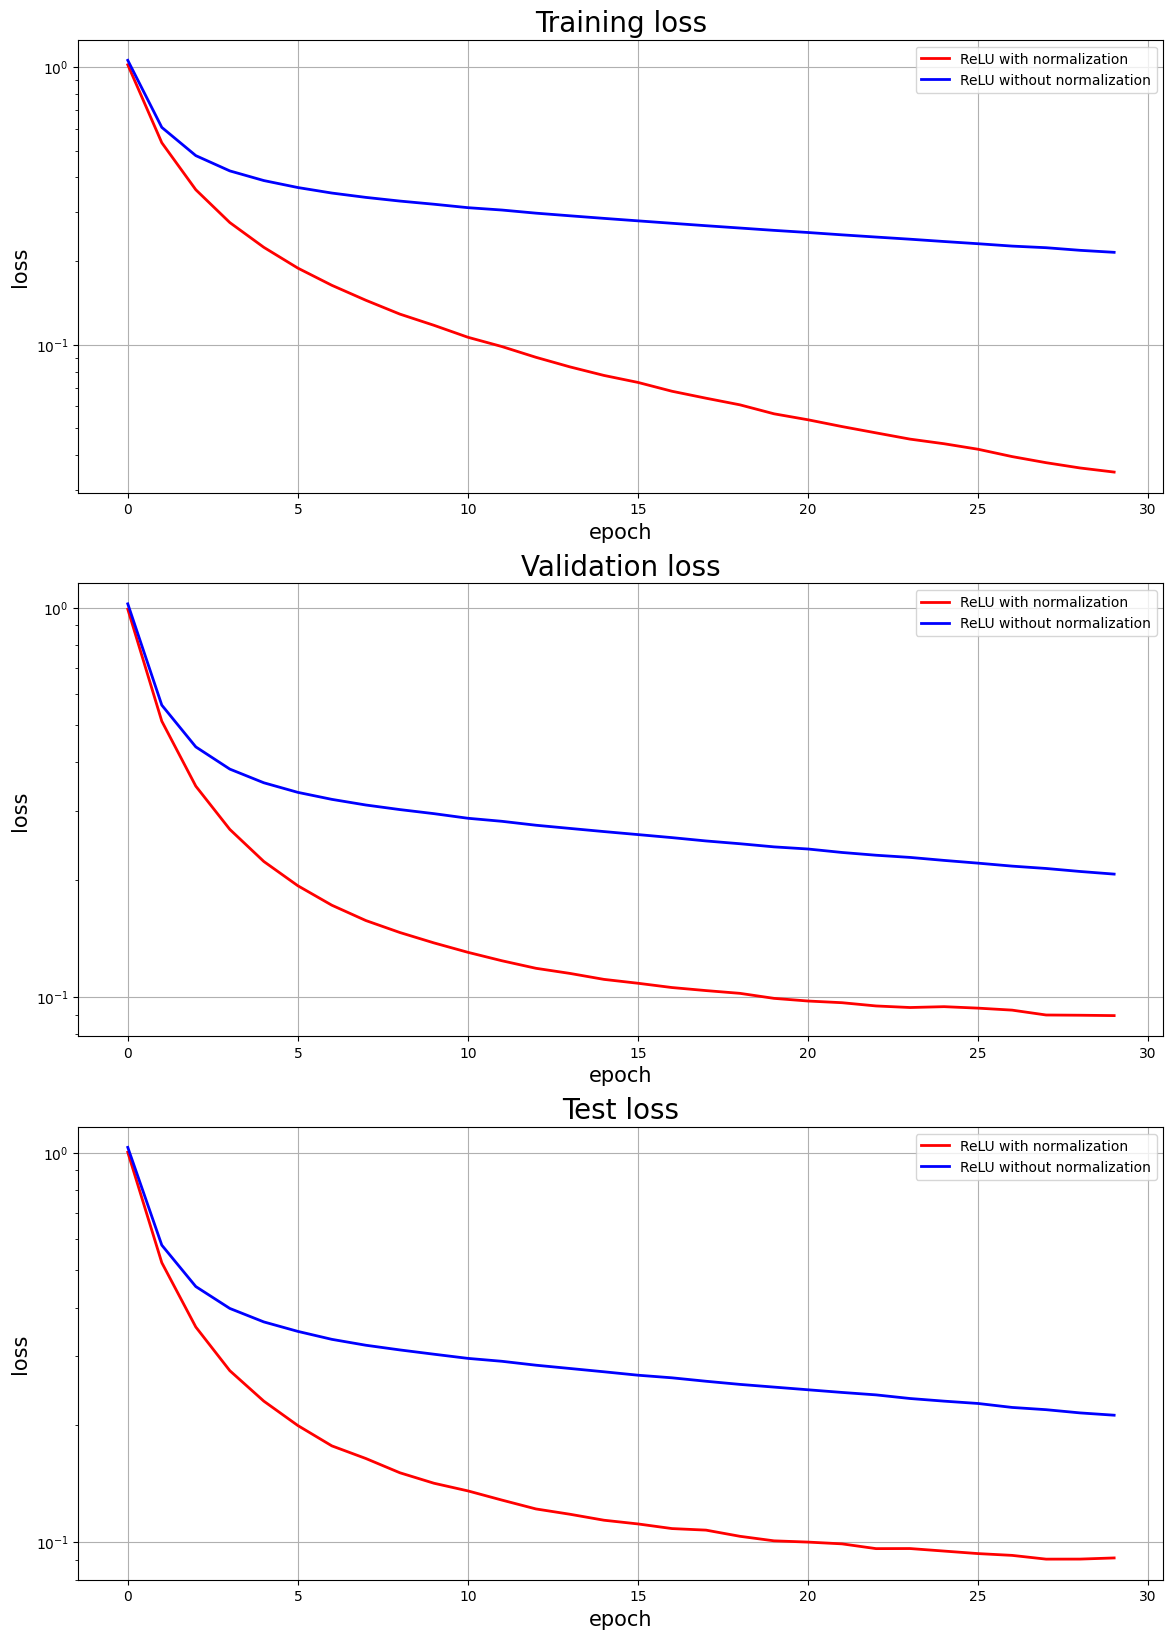

Resulting duration of training: 
 for ReLU without normalization: 556.799 s, 
 for ReLU with normalization: 565.5062 s


In [ ]:
val_loss_r = []
train_loss_r = []
test_loss_r = []

val_loss_norm = []
train_loss_norm = []
test_loss_norm = []

time_r = 0
time_norm = 0

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        net_r.zeroGradParameters()
        net_norm.zeroGradParameters()

        time_r_start = time()
        predictions_r = net_r.forward(x_batch)
        loss_r = criterion_r.forward(predictions_r, y_batch)
        dp_r = criterion_r.backward(predictions_r, y_batch)
        net_r.backward(x_batch, dp_r)
        sgd_momentum(net_r.getParameters(),
                     net_r.getGradParameters(),
                     {'learning_rate' : 1e-1, 'momentum': 0.9},
                     {})
        time_r += time() - time_r_start

        time_norm_start = time()
        predictions_norm = net_norm.forward(x_batch)
        loss_norm = criterion_norm.forward(predictions_norm, y_batch)
        dp_norm = criterion_norm.backward(predictions_norm, y_batch)
        net_norm.backward(x_batch, dp_norm)
        sgd_momentum(net_norm.getParameters(),
                      net_norm.getGradParameters(),
                       {'learning_rate' : 1e-1, 'momentum': 0.9},
                       {})

        time_norm += time() - time_norm_start

    pred_train_r = net_r.forward(X_train)
    train_loss_r.append(criterion_r.forward(pred_train_r, one_hot_y_train))
    pred_val_r = net_r.forward(X_val)
    val_loss_r.append(criterion.forward(pred_val_r, one_hot_y_val))
    pred_test_r = net_r.forward(X_test)
    test_loss_r.append(criterion_r.forward(pred_test_r, one_hot_y_test))


    pred_train_norm = net_norm.forward(X_train)
    train_loss_norm.append(criterion_norm.forward(pred_train_norm, one_hot_y_train))
    pred_val_norm = net_norm.forward(X_val)
    val_loss_norm.append(criterion.forward(pred_val_norm, one_hot_y_val))
    pred_test_norm = net_norm.forward(X_test)
    test_loss_norm.append(criterion_norm.forward(pred_test_norm, one_hot_y_test))

    display.clear_output(wait=True)
    print('n_epoch = {} out of {}'.format(i+1,n_epoch))
    print('Current duration of training: \n for ReLU without normalization: {} s, \n for ReLU with normalization: {} s'.format(round(time_r,4), round(time_norm,4)))
    plt.figure(figsize=(14, 20))

    plt.subplot(3,1,1)
    plt.title("Training loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(train_loss_norm, lw = 2, color = 'r', label = 'ReLU with normalization')
    plt.semilogy(train_loss_r, lw = 2, color ='b', label = 'ReLU without normalization')
    plt.grid(True)
    plt.legend()

    plt.subplot(3,1,2)
    plt.title("Validation loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(val_loss_norm, lw = 2, color ='r', label = 'ReLU with normalization')
    plt.semilogy(val_loss_r, lw = 2, color ='b', label = 'ReLU without normalization')
    plt.grid(True)
    plt.legend()

    plt.subplot(3,1,3)
    plt.title("Test loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_loss_norm, lw = 2, color='r', label = 'ReLU with normalization')
    plt.semilogy(test_loss_r, lw = 2, color='b', label = 'ReLU without normalization')
    plt.grid(True)
    plt.legend()

    plt.show()

print('Resulting duration of training: \n for ReLU without normalization: {} s, \n for ReLU with normalization: {} s'.format(round(time_r,4), round(time_norm,4)))


Согласно графикам можно сделать вывод, что батч-нормализация улучшает показатели точности. При этом скорость работы остается такой же

Optimizers compare

n_epoch = 60 out of 60
Current duration of training: 
 for ELU SGD optimizer: 1115.6728 s, 
 for ELU Adam optimizer: 1118.9593 s


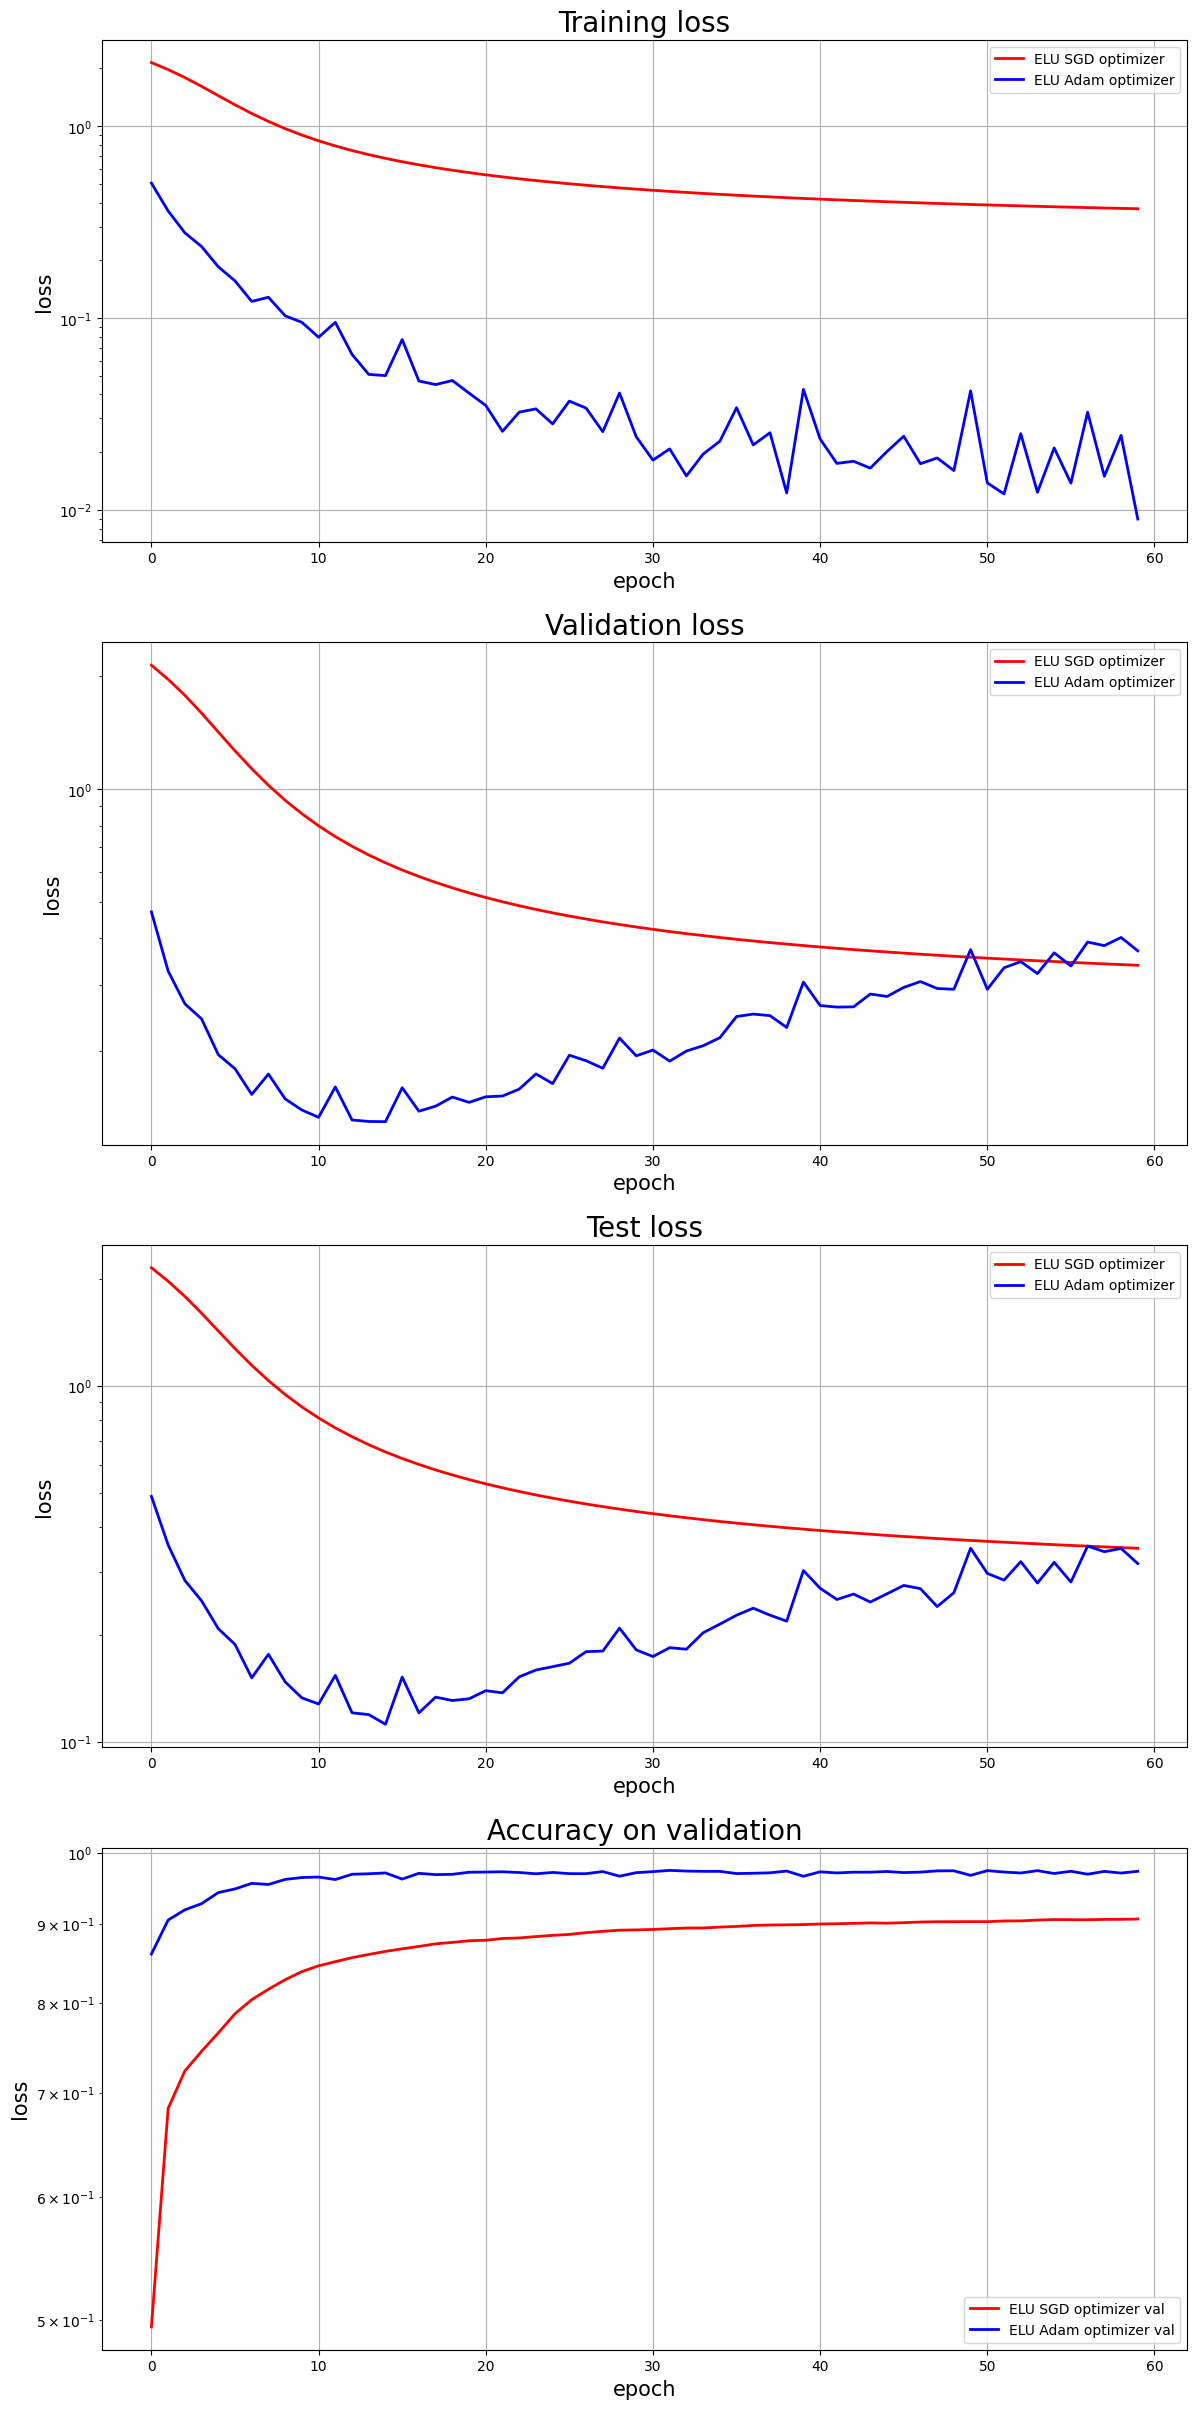

Resulting duration of training: 
 for ELU SGD optimizer: 1115.6728 s, 
 for ELU Adam optimizer: 1118.9593 s


In [ ]:
n_epoch = 60
batch_size = 1000

net_1 = Sequential()
net_1.add(Linear(28*28, 100))
net_1.add(ELU())
net_1.add(Linear(100,10))
net_1.add(LogSoftMax())
criterion_1 = ClassNLLCriterion()

net_2 = Sequential()
net_2.add(Linear(28*28, 100))
net_2.add(ELU())
net_2.add(Linear(100,10))
net_2.add(LogSoftMax())
criterion_2 = ClassNLLCriterion()


train_loss_1 = []
val_loss_1 = []
test_loss_1 = []
train_acc_1 = []
val_acc_1 = []
train_loss_2 = []
val_loss_2 = []
test_loss_2 = []
train_acc_2 = []
val_acc_2 = []
time_1 = 0
time_2 = 0

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        net_1.zeroGradParameters()
        net_2.zeroGradParameters()

        time_1_start = time()
        predictions_1 = net_1.forward(x_batch)
        loss_1 = criterion_1.forward(predictions_1, y_batch)
        dp_1 = criterion_1.backward(predictions_1, y_batch)
        net_1.backward(x_batch, dp_1)
        sgd_momentum(net_1.getParameters(),
                     net_1.getGradParameters(),
                     {'learning_rate' : 1e-2, 'momentum': 0.9},
                     {})
        time_1 += time() - time_1_start

        time_2_start = time()
        predictions_2 = net_2.forward(x_batch)
        loss_norm = criterion_2.forward(predictions_2, y_batch)
        dp_2 = criterion_2.backward(predictions_2, y_batch)
        net_2.backward(x_batch, dp_2)
        adam_optimizer(net_2.getParameters(), net_2.getGradParameters(), {'learning_rate': 1e-2, 'beta1':0.9, 'beta2':0.99, 'epsilon': 1e-8}, {})
        time_2 += time() - time_2_start

    pred_train_1 = net_1.forward(X_train)
    train_loss_1.append(criterion_1.forward(pred_train_1, one_hot_y_train))
    pred_val_1 = net_1.forward(X_val)
    val_acc_1.append(accuracy(pred_val_1, np.argmax(one_hot_y_val, axis = -1)))
    val_loss_1.append(criterion_1.forward(pred_val_1, one_hot_y_val))
    pred_test_1 = net_1.forward(X_test)
    test_loss_1.append(criterion_1.forward(pred_test_1, one_hot_y_test))


    pred_train_2 = net_2.forward(X_train)
    train_loss_2.append(criterion_2.forward(pred_train_2, one_hot_y_train))
    pred_val_2 = net_2.forward(X_val)
    val_loss_2.append(criterion_2.forward(pred_val_2, one_hot_y_val))
    val_acc_2.append(accuracy(pred_val_2, np.argmax(one_hot_y_val, axis = -1)))
    pred_test_2 = net_2.forward(X_test)
    test_loss_2.append(criterion_2.forward(pred_test_2, one_hot_y_test))

    display.clear_output(wait=True)
    print('n_epoch = {} out of {}'.format(i+1,n_epoch))
    print('Current duration of training: \n for ELU SGD optimizer: {} s, \n for ELU Adam optimizer: {} s'.format(round(time_1,4), round(time_2,4)))
    plt.figure(figsize=(14, 30))

    plt.subplot(4,1,1)
    plt.title("Training loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(train_loss_1, lw = 2, color='r', label = 'ELU SGD optimizer')
    plt.semilogy(train_loss_2, lw = 2, color='b', label = 'ELU Adam optimizer')
    plt.grid(True)
    plt.legend()

    plt.subplot(4,1,2)
    plt.title("Validation loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(val_loss_1, lw = 2, color='r', label = 'ELU SGD optimizer')
    plt.semilogy(val_loss_2, lw = 2, color='b', label = 'ELU Adam optimizer')
    plt.grid(True)
    plt.legend()

    plt.subplot(4,1,3)
    plt.title("Test loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_loss_1, lw = 2, color='r', label = 'ELU SGD optimizer')
    plt.semilogy(test_loss_2, lw = 2, color='b', label = 'ELU Adam optimizer')
    plt.grid(True)
    plt.legend()

    plt.subplot(4,1,4)
    plt.title("Accuracy on validation", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(val_acc_1, lw = 2, color='r', label = 'ELU SGD optimizer val')
    plt.semilogy(val_acc_2, lw = 2, color='b', label = 'ELU Adam optimizer val')
    plt.grid(True)
    plt.legend()

    plt.show()

print('Resulting duration of training: \n for ELU SGD optimizer: {} s, \n for ELU Adam optimizer: {} s'.format(round(time_1,4), round(time_2,4)))

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################
net_w = Sequential()
net_w.add(Linear(28*28, 600))
net_w.add(Dropout(0.9))
net_w.add(ELU())
net_w.add(Linear(600,10))
net_w.add(LogSoftMax())
criterion_w = ClassNLLCriterion()

net_wo = Sequential()
net_wo.add(Linear(28*28, 600))
net_wo.add(ELU())
net_wo.add(Linear(600,10))
net_wo.add(LogSoftMax())
criterion_wo = ClassNLLCriterion()


n_epoch = 100
batch_size = 1000
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

val_acc_w = []
val_loss_w = []
train_acc_w = []
train_loss_w = []


val_acc_wo = []
val_loss_wo = []
train_acc_wo = []
train_loss_wo = []


for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):

        net_w.zeroGradParameters()
        net_wo.zeroGradParameters()


        predictions_w = net_w.forward(x_batch)
        loss_w = criterion_w.forward(predictions_w, y_batch)
        dp_w = criterion_w.backward(predictions_w, y_batch)
        net_w.backward(x_batch, dp_w)
        sgd_momentum(net_w.getParameters(),
                     net_w.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        predictions_wo = net_wo.forward(x_batch)
        loss_wo = criterion_wo.forward(predictions_wo, y_batch)
        dp_wo = criterion_wo.backward(predictions_wo, y_batch)
        net_wo.backward(x_batch, dp_wo)
        sgd_momentum(net_wo.getParameters(),
                     net_wo.getGradParameters(),
                     optimizer_config,
                     optimizer_state)


    pred_train_w = net_w.forward(X_train)
    train_loss_w.append(criterion_w.forward(pred_train_w, one_hot_y_train))
    train_acc_w.append(accuracy(pred_train_w,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_w = net_w.forward(X_val)
    val_loss_w.append(criterion_w.forward(pred_val_w, one_hot_y_val))
    val_acc_w.append(accuracy(pred_val_w,np.argmax(one_hot_y_val,axis = -1)))



    pred_train_wo = net_wo.forward(X_train)
    train_loss_wo.append(criterion_wo.forward(pred_train_wo, one_hot_y_train))
    train_acc_wo.append(accuracy(pred_train_wo,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_wo = net_wo.forward(X_val)
    val_loss_wo.append(criterion_wo.forward(pred_val_wo, one_hot_y_val))
    val_acc_wo.append(accuracy(pred_val_wo,np.argmax(one_hot_y_val,axis = -1)))


n_epoch = 100 out of 100


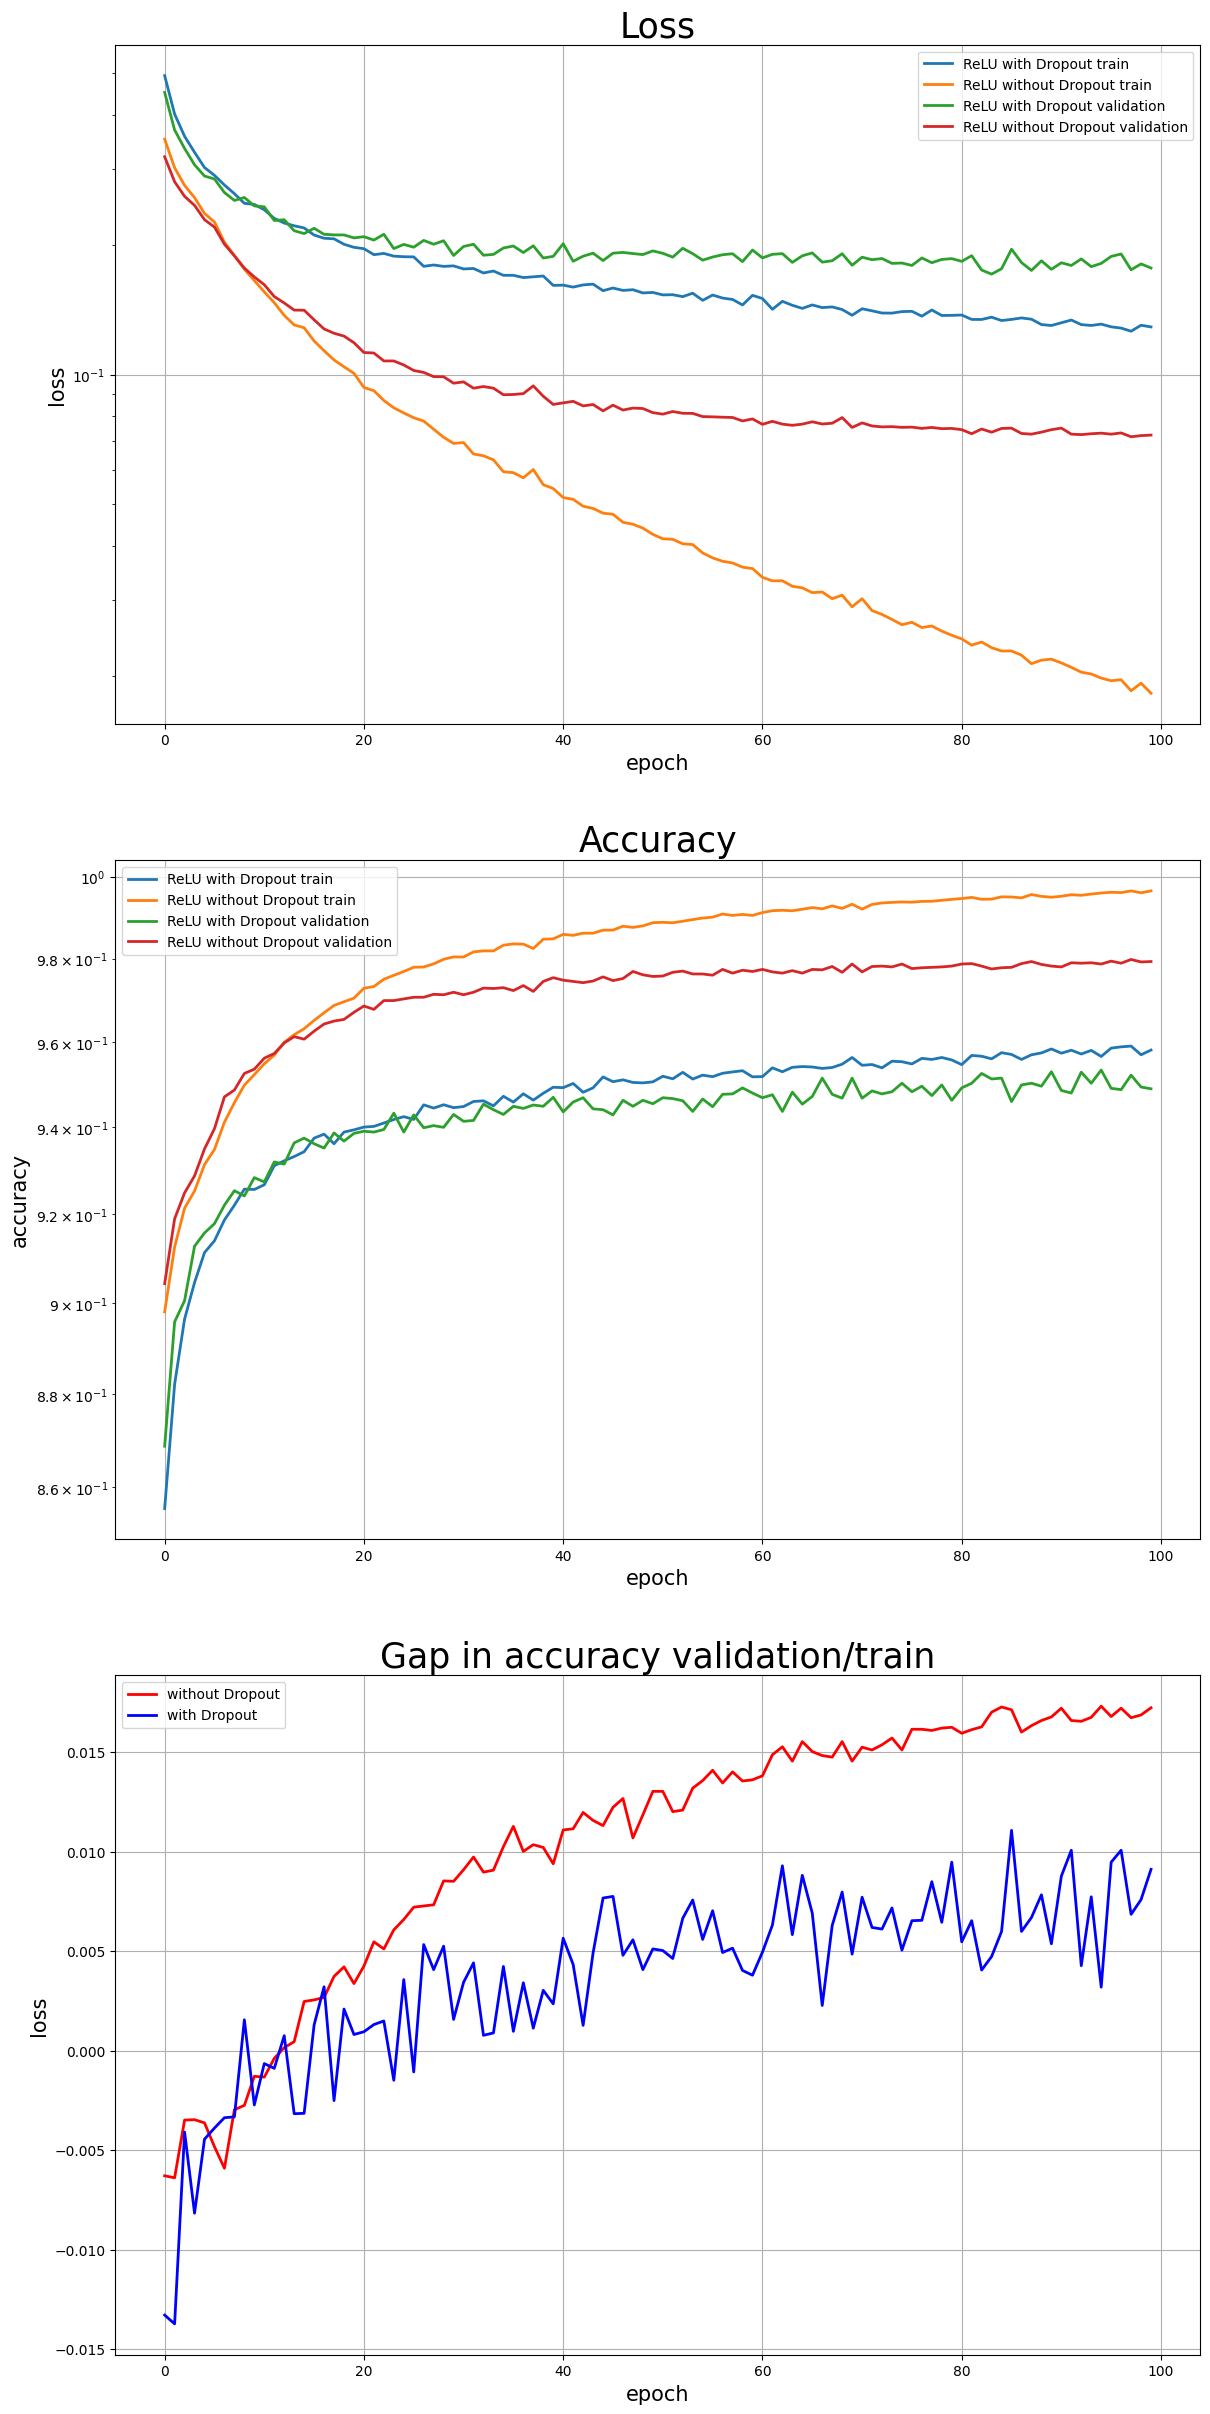

In [ ]:
display.clear_output(wait=True)
print('n_epoch = {} out of {}'.format(i+1,n_epoch))
plt.figure(figsize=(14, 30))

plt.subplot(3,1,1)
plt.title("Loss", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(train_loss_w, lw = 2, label = 'ReLU with Dropout train')
plt.semilogy(train_loss_wo, lw = 2, label = 'ReLU without Dropout train')
plt.semilogy(val_loss_w, lw = 2, label = 'ReLU with Dropout validation')
plt.semilogy(val_loss_wo, lw = 2, label = 'ReLU without Dropout validation')
plt.grid(True)
plt.legend()


plt.subplot(3,1,2)
plt.title("Accuracy", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("accuracy", fontsize = 15)
plt.semilogy(train_acc_w, lw = 2, label = 'ReLU with Dropout train')
plt.semilogy(train_acc_wo, lw = 2, label = 'ReLU without Dropout train')
plt.semilogy(val_acc_w, lw = 2, label = 'ReLU with Dropout validation')
plt.semilogy(val_acc_wo, lw = 2, label = 'ReLU without Dropout validation')
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.title("Gap in accuracy validation/train", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.plot(np.array(train_acc_wo) - np.array(val_acc_wo), lw = 2,  color = 'r', label = 'without Dropout')
plt.plot(np.array(train_acc_w) - np.array(val_acc_w), lw = 2, color = 'b', label = 'with Dropout')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
net_w_2 = Sequential()
net_w_2.add(Linear(28*28, 600))
net_w_2.add(Dropout(0.9))
net_w_2.add(ELU())
net_w_2.add(Linear(600,10))
net_w_2.add(LogSoftMax())
criterion_w = ClassNLLCriterion()

net_wo_2 = Sequential()
net_wo_2.add(Linear(28*28, 600))
net_wo_2.add(ELU())
net_wo_2.add(Linear(600,10))
net_wo_2.add(LogSoftMax())
criterion_wo = ClassNLLCriterion()


n_epoch = 30
batch_size = 1000
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

val_acc_w_2 = []
val_loss_w_2 = []
train_acc_w_2 = []
train_loss_w_2 = []

val_acc_wo_2 = []
val_loss_wo_2 = []
train_acc_wo_2 = []
train_loss_wo_2 = []

test_acc_w = []
test_loss_w = []
test_acc_wo = []
test_loss_wo = []

for epoch in range(n_epoch):
    net_w_2.train()
    net_wo_2.train()
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        net_w_2.zeroGradParameters()
        net_wo_2.zeroGradParameters()

        predictions_w = net_w_2.forward(x_batch)
        loss_w = criterion_w.forward(predictions_w, y_batch)
        dp_w = criterion_w.backward(predictions_w, y_batch)
        net_w_2.backward(x_batch, dp_w)
        sgd_momentum(net_w_2.getParameters(),
                     net_w_2.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        predictions_wo = net_wo_2.forward(x_batch)
        loss_wo = criterion_wo.forward(predictions_wo, y_batch)
        dp_wo = criterion_wo.backward(predictions_wo, y_batch)
        net_wo_2.backward(x_batch, dp_wo)
        sgd_momentum(net_wo_2.getParameters(),
                     net_wo_2.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

    pred_train_w = net_w_2.forward(X_train)
    train_loss_w_2.append(criterion_w.forward(pred_train_w, one_hot_y_train))
    train_acc_w_2.append(accuracy(pred_train_w, np.argmax(one_hot_y_train, axis=-1)))

    pred_val_w = net_w_2.forward(X_val)
    val_loss_w_2.append(criterion_w.forward(pred_val_w, one_hot_y_val))
    val_acc_w_2.append(accuracy(pred_val_w, np.argmax(one_hot_y_val, axis=-1)))

    pred_train_wo = net_wo_2.forward(X_train)
    train_loss_wo_2.append(criterion_wo.forward(pred_train_wo, one_hot_y_train))
    train_acc_wo_2.append(accuracy(pred_train_wo, np.argmax(one_hot_y_train, axis=-1)))

    pred_val_wo = net_wo_2.forward(X_val)
    val_loss_wo_2.append(criterion_wo.forward(pred_val_wo, one_hot_y_val))
    val_acc_wo_2.append(accuracy(pred_val_wo, np.argmax(one_hot_y_val, axis=-1)))

    net_w_2.evaluate()
    pred_test_w = net_w_2.forward(X_test)
    test_loss_w.append(criterion_w.forward(pred_test_w, one_hot_y_test))
    test_acc_w.append(accuracy(pred_test_w, np.argmax(one_hot_y_test, axis=-1)))

    net_wo_2.evaluate()
    pred_test_wo = net_wo_2.forward(X_test)
    test_loss_wo.append(criterion_wo.forward(pred_test_wo, one_hot_y_test))
    test_acc_wo.append(accuracy(pred_test_wo, np.argmax(one_hot_y_test, axis=-1)))

    print(f'Epoch {epoch + 1}/{n_epoch}')
    print(f'  Train Loss (net_w): {train_loss_w_2[-1]:.4f}, Train Accuracy (net_w): {train_acc_w_2[-1]:.4f}')
    print(f'  Val Loss (net_w): {val_loss_w_2[-1]:.4f}, Val Accuracy (net_w): {val_acc_w_2[-1]:.4f}')
    print(f'  Test Loss (net_w): {test_loss_w[-1]:.4f}, Test Accuracy (net_w): {test_acc_w[-1]:.4f}')
    print(f'  Train Loss (net_wo): {train_loss_wo_2[-1]:.4f}, Train Accuracy (net_wo): {train_acc_wo_2[-1]:.4f}')
    print(f'  Val Loss (net_wo): {val_loss_wo_2[-1]:.4f}, Val Accuracy (net_wo): {val_acc_wo_2[-1]:.4f}')
    print(f'  Test Loss (net_wo): {test_loss_wo[-1]:.4f}, Test Accuracy (net_wo): {test_acc_wo[-1]:.4f}')



Epoch 1/30
  Train Loss (net_w): 0.4982, Train Accuracy (net_w): 0.8521
  Val Loss (net_w): 0.4557, Val Accuracy (net_w): 0.8689
  Test Loss (net_w): 0.3375, Test Accuracy (net_w): 0.9010
  Train Loss (net_wo): 0.3499, Train Accuracy (net_wo): 0.8983
  Val Loss (net_wo): 0.3192, Val Accuracy (net_wo): 0.9066
  Test Loss (net_wo): 0.3306, Test Accuracy (net_wo): 0.9044
Epoch 2/30
  Train Loss (net_w): 0.4049, Train Accuracy (net_w): 0.8827
  Val Loss (net_w): 0.3734, Val Accuracy (net_w): 0.8926
  Test Loss (net_w): 0.3188, Test Accuracy (net_w): 0.9066
  Train Loss (net_wo): 0.3077, Train Accuracy (net_wo): 0.9106
  Val Loss (net_wo): 0.2867, Val Accuracy (net_wo): 0.9161
  Test Loss (net_wo): 0.2952, Test Accuracy (net_wo): 0.9147
Epoch 3/30
  Train Loss (net_w): 0.3568, Train Accuracy (net_w): 0.8958
  Val Loss (net_w): 0.3391, Val Accuracy (net_w): 0.9021
  Test Loss (net_w): 0.3000, Test Accuracy (net_w): 0.9150
  Train Loss (net_wo): 0.2776, Train Accuracy (net_wo): 0.9210
  Val L

Print here your accuracy on test set. It should be around 90%.

In [ ]:
print(f'accuracy with DropOut: {test_acc_w[-1]}')
print(f'accuracy without DropOut: {test_acc_wo[-1]}')


accuracy with DropOut: 0.9079
accuracy without DropOut: 0.9693


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetWO(nn.Module):
    def __init__(self):
        super(NetWO, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 600)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(600, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.elu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

net_wo_torch = NetWO()

criterion_wo = nn.CrossEntropyLoss()

NetWO(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (elu): ELU(alpha=1.0)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                               torch.tensor(one_hot_y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(one_hot_y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer_config = {
    'lr': 0.01,
    'momentum': 0.9
}
optimizer = torch.optim.SGD(net_wo_torch.parameters(), lr=optimizer_config['lr'], momentum=optimizer_config['momentum'])

train_loss_wo = []
train_acc_wo = []
val_loss_wo = []
val_acc_wo = []

for epoch in range(n_epoch):
    net_wo_torch.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()

        predictions_wo = net_wo_torch(x_batch)

        loss_wo = criterion_wo(predictions_wo, torch.max(y_batch, 1)[1])

        loss_wo.backward()

        optimizer.step()

    net_wo_torch.eval()
    with torch.no_grad():
        pred_train_wo = net_wo_torch(torch.tensor(X_train, dtype=torch.float32))
        train_loss = criterion_wo(pred_train_wo, torch.max(torch.tensor(one_hot_y_train, dtype=torch.float32), 1)[1])
        train_acc = accuracy(pred_train_wo, torch.argmax(torch.tensor(one_hot_y_train), dim=-1))

        train_loss_wo.append(train_loss.item())
        train_acc_wo.append(train_acc)

        pred_val_wo = net_wo_torch(torch.tensor(X_val, dtype=torch.float32))
        val_loss = criterion_wo(pred_val_wo, torch.max(torch.tensor(one_hot_y_val, dtype=torch.float32), 1)[1])
        val_acc = accuracy(pred_val_wo, torch.argmax(torch.tensor(one_hot_y_val), dim=-1))

        val_loss_wo.append(val_loss.item())
        val_acc_wo.append(val_acc)

    print(f'Epoch {epoch+1}/{n_epoch}, Train Loss: {train_loss_wo[-1]:.4f}, Train Accuracy: {train_acc_wo[-1]:.4f}, '
          f'Val Loss: {val_loss_wo[-1]:.4f}, Val Accuracy: {val_acc_wo[-1]:.4f}')

Epoch 1/40, Train Loss: 0.4331, Train Accuracy: 1.0000, Val Loss: 0.3945, Val Accuracy: 0.9999
Epoch 2/40, Train Loss: 0.3976, Train Accuracy: 1.0000, Val Loss: 0.3629, Val Accuracy: 0.9999
Epoch 3/40, Train Loss: 0.3761, Train Accuracy: 1.0000, Val Loss: 0.3448, Val Accuracy: 0.9999
Epoch 4/40, Train Loss: 0.3607, Train Accuracy: 1.0000, Val Loss: 0.3312, Val Accuracy: 0.9999
Epoch 5/40, Train Loss: 0.3491, Train Accuracy: 1.0000, Val Loss: 0.3215, Val Accuracy: 0.9999
Epoch 6/40, Train Loss: 0.3397, Train Accuracy: 1.0000, Val Loss: 0.3139, Val Accuracy: 0.9999
Epoch 7/40, Train Loss: 0.3325, Train Accuracy: 1.0000, Val Loss: 0.3074, Val Accuracy: 0.9999
Epoch 8/40, Train Loss: 0.3263, Train Accuracy: 1.0000, Val Loss: 0.3025, Val Accuracy: 0.9999
Epoch 9/40, Train Loss: 0.3210, Train Accuracy: 1.0000, Val Loss: 0.2985, Val Accuracy: 0.9999
Epoch 10/40, Train Loss: 0.3166, Train Accuracy: 1.0000, Val Loss: 0.2954, Val Accuracy: 0.9999
Epoch 11/40, Train Loss: 0.3132, Train Accuracy: 